# Diffusion Mnist

In [1]:
# Install required libraries
!pip install torch torchvision einops matplotlib tqdm torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // Config.ATTENTION_DIM_REDUCTION, 1)
        self.key = nn.Conv2d(in_channels, in_channels // Config.ATTENTION_DIM_REDUCTION, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, channels, height, width = x.size()
        query = self.query(x).view(batch, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch, -1, height * width)
        attention = torch.bmm(query, key)
        attention = torch.softmax(attention, dim=-1)
        value = self.value(x).view(batch, -1, height * width)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        return self.gamma * out + x


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, channels):
        super().__init__()
        layers = []
        for in_ch, out_ch in zip(channels[:-1], channels[1:]):
            layers.append(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1))
            layers.append(nn.ReLU())
            if out_ch in Config.ATTENTION_LAYERS:  # Add attention selectively
                layers.append(SelfAttention(out_ch))
        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels[-1] * 7 * 7, latent_dim),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, channels):
        super().__init__()
        self.linear = nn.Linear(latent_dim, channels[0] * 7 * 7)
        layers = []
        for in_ch, out_ch in zip(channels[:-1], channels[1:]):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1))
            layers.append(nn.ReLU() if out_ch != 1 else nn.Sigmoid())
            if out_ch in Config.ATTENTION_LAYERS:  # Add attention selectively
                layers.append(SelfAttention(out_ch))
        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = rearrange(x, "b (c h w) -> b c h w", c=channels[0], h=7, w=7)
        x = self.deconv_layers(x)
        return x


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=Config.LATENT_DIM):
        super().__init__()
        self.encoder = Encoder(latent_dim, Config.ENCODER_CHANNELS)
        self.decoder = Decoder(latent_dim, Config.DECODER_CHANNELS)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
def train_autoencoder():
    # Load data
    train_loader = get_mnist_dataloader(train=True)

    # Initialize model, loss, and optimizer
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    summary(autoencoder, input_size=(1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=Config.LR)

    loss_history = []
    # Training loop
    autoencoder.train()
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.EPOCHS}")
        for images, _ in pbar:
            images = images.to(Config.DEVICE)

            # Forward pass
            recon_images = autoencoder(images)
            loss = criterion(recon_images, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        average_loss = epoch_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}: Average Loss: {average_loss:.4f}")

    # Save the trained model
    save_path = os.path.join(Config.SAVE_DIR, "First_Autoencoder_with_Attention.pth")
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder training completed and model saved at: {save_path}")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Config.EPOCHS + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def train_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    for epoch in range(Config.EPOCHS):
        for images, _ in dataloader:
            images = images.to(Config.DEVICE)
            loss = model.training_step(images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{Config.EPOCHS}, Loss: {loss.item()}")


In [ ]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "First_Autoencoder_with_Attention.pth"
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]  # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]  # Latent -> Intermediate -> Output
    ATTENTION_DIM_REDUCTION = 8    # Self-attention channel reduction factor

In [ ]:
os.makedirs(Config.SAVE_DIR, exist_ok=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3            [-1, 2, 14, 14]              34
            Conv2d-4            [-1, 2, 14, 14]              34
            Conv2d-5           [-1, 16, 14, 14]             272
     SelfAttention-6           [-1, 16, 14, 14]               0
            Conv2d-7             [-1, 32, 7, 7]           4,640
              ReLU-8             [-1, 32, 7, 7]               0
            Conv2d-9              [-1, 4, 7, 7]             132
           Conv2d-10              [-1, 4, 7, 7]             132
           Conv2d-11             [-1, 32, 7, 7]           1,056
    SelfAttention-12             [-1, 32, 7, 7]               0
          Flatten-13                 [-1, 1568]               0
           Linear-14                   

Epoch 1/10: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s, Loss=0.0391]


Epoch 1: Average Loss: 0.0718


Epoch 2/10: 100%|██████████| 938/938 [00:17<00:00, 53.89it/s, Loss=0.0178]


Epoch 2: Average Loss: 0.0241


Epoch 3/10: 100%|██████████| 938/938 [00:18<00:00, 52.09it/s, Loss=0.0130]


Epoch 3: Average Loss: 0.0155


Epoch 4/10: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s, Loss=0.0108]


Epoch 4: Average Loss: 0.0122


Epoch 5/10: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s, Loss=0.0097]


Epoch 5: Average Loss: 0.0103


Epoch 6/10: 100%|██████████| 938/938 [00:17<00:00, 53.75it/s, Loss=0.0086]


Epoch 6: Average Loss: 0.0091


Epoch 7/10: 100%|██████████| 938/938 [00:17<00:00, 52.14it/s, Loss=0.0083]


Epoch 7: Average Loss: 0.0082


Epoch 8/10: 100%|██████████| 938/938 [00:17<00:00, 54.04it/s, Loss=0.0063]


Epoch 8: Average Loss: 0.0076


Epoch 9/10: 100%|██████████| 938/938 [00:17<00:00, 54.31it/s, Loss=0.0059]


Epoch 9: Average Loss: 0.0072


Epoch 10/10: 100%|██████████| 938/938 [00:17<00:00, 53.75it/s, Loss=0.0077]


Epoch 10: Average Loss: 0.0068
Autoencoder training completed and model saved at: /content/drive/My Drive/AI/Projects/diffusion mnist/models/First_Autoencoder_with_Attention.pth


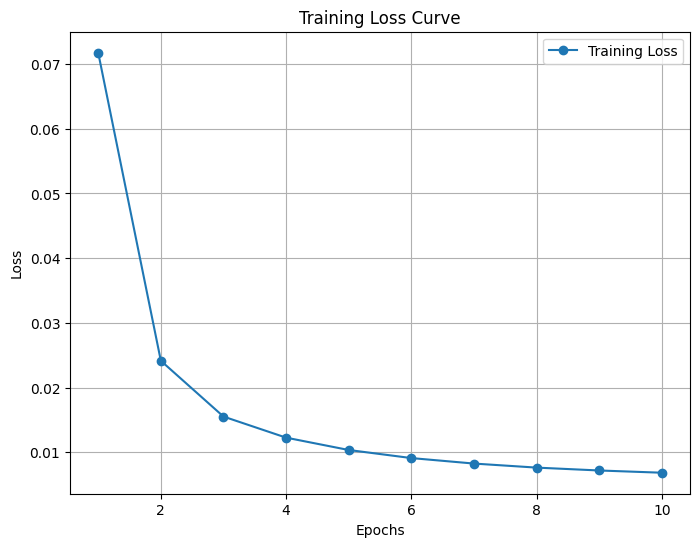

In [ ]:
train_autoencoder()


In [ ]:
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    ssim_scores = []
    psnr_scores = []

    for i in range(original.shape[0]):
        original_img = original[i, 0]
        reconstructed_img = reconstructed[i, 0]

        ssim_score = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
        psnr_score = psnr(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    return np.mean(ssim_scores), np.mean(psnr_scores)

In [ ]:
def visualize_reconstructions():
    # Load the model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Get test data
    test_loader = get_mnist_dataloader(train=False)
    images, _ = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    # Reconstruct
    with torch.no_grad():
        recon_images = autoencoder(images)

    # Calculate metrics
    avg_ssim, avg_psnr = calculate_metrics(images, recon_images)
    print(f"Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.2f}")

    # Visualization
    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(18, 6))
    fig.suptitle(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}", fontsize=16, y=0.92)

    for i in range(num_images):
        original_img = images[i][0].cpu().numpy()
        reconstructed_img = recon_images[i][0].cpu().numpy()

        # Original images
        axes[0, i].imshow(original_img, cmap="gray")
        ssim_score = ssim(original_img, reconstructed_img, data_range=1.0)
        axes[0, i].set_title(f"Original", fontsize=10)
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(reconstructed_img, cmap="gray")
        axes[1, i].set_title(f"Reconstructed\nSSIM: {ssim_score:.2f}", fontsize=10)
        axes[1, i].axis("off")

    # plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


<ipython-input-53-d7b8f594bd62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


Average SSIM: 0.9338, Average PSNR: 22.88


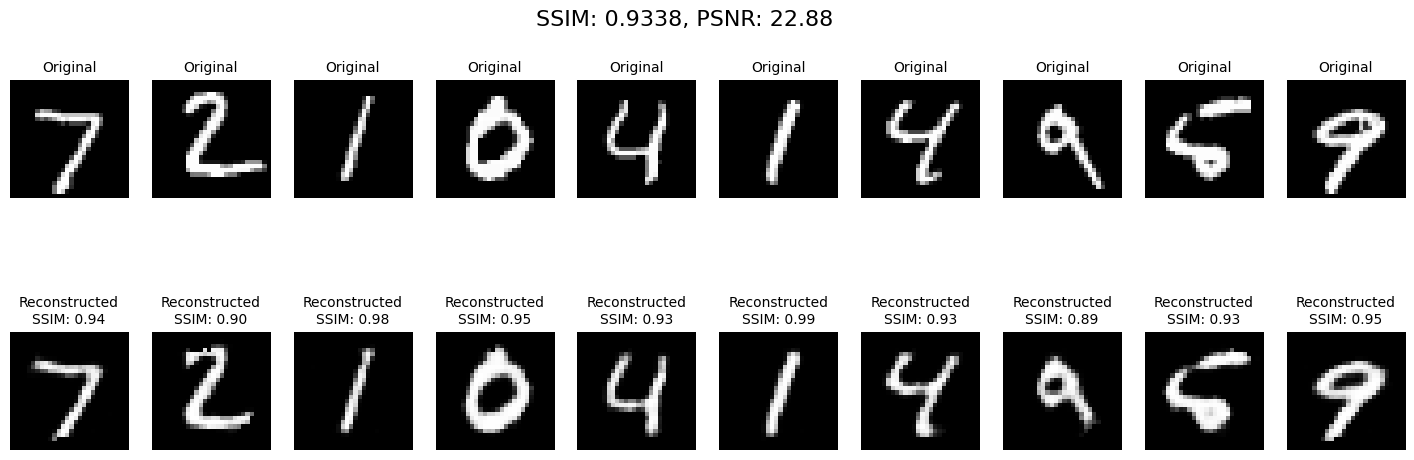

In [ ]:
visualize_reconstructions()


In [ ]:
def visualize_latent_space():
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM, image_size=Config.IMAGE_SIZE).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load("autoencoder.pth"))
    autoencoder.eval()

    test_loader = get_mnist_dataloader(train=False)
    images, labels = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    with torch.no_grad():
        latents = autoencoder.encode(images).cpu().numpy()

    # Use PCA or t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter, label="Digit Label")
    plt.title("Latent Space Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
